In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sns.set_style("whitegrid")
torch.manual_seed(0)
np.random.seed(0)

# Data Loading, Cleaning, EDA

In [160]:
train_path = "dataset/delhi-climate-data/DailyDelhiClimateTrain.csv"
test_path = "dataset/delhi-climate-data/DailyDelhiClimateTest.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

def clean_df(df):
    return (df
        .loc[:, ["date", "meantemp"]]
        .sort_values("date", ascending=True)
        .assign(
            date=lambda df_: pd.to_datetime(df_["date"]), 
            meantemp=lambda df_: df_["meantemp"].astype("float32")
        )
        .set_index("date")
        .resample("1d")
        .ffill()
        .reset_index()
    )

df_train = clean_df(df_train)
df_test = clean_df(df_test)

print(df_train.shape, df_test.shape)
df_train.head()

(1462, 2) (114, 2)


,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


# Create Dataset

In [161]:
x_train = df_train["meantemp"].values[:-114]
x_val = df_train["meantemp"].values[-114:]
x_test = df_test["meantemp"].values

x_train_looped = []
for i in range(x_train.shape[0]):
    x = np.array(x_train[i : i + 13])
    if x.shape[0] == 13:
        x_train_looped.append(x.reshape(1, 13))
x_train_looped = np.array(x_train_looped).reshape(-1, 13)


x_val_looped = []
for i in range(x_val.shape[0]):
    x = np.array(x_val[i : i + 13])
    if x.shape[0] == 13:
        x_val_looped.append(x.reshape(1, 13))
x_val_looped = np.array(x_val_looped).reshape(-1, 13)


x_test_looped = []
for i in range(x_test.shape[0]):
    x = np.array(x_test[i : i + 13])
    if x.shape[0] == 13:
        x_test_looped.append(x.reshape(1, 13))
x_test_looped = np.array(x_test_looped).reshape(-1, 13)

print(x_train_looped.shape, x_val_looped.shape, x_test_looped.shape)

(1336, 13) (102, 13) (102, 13)


For training set, this is 1450 samples, each consisting of 13 months, etc for val and test set.

Next we need to create y from this.

In [162]:
x_train_tensor = torch.from_numpy(x_train_looped[:, :-1]).unsqueeze(dim=-1)
x_val_tensor = torch.from_numpy(x_val_looped[:, :-1]).unsqueeze(dim=-1)
x_test_tensor = torch.from_numpy(x_test_looped[:, :-1]).unsqueeze(dim=-1)

y_train_tensor = torch.from_numpy(x_train_looped[:, -1]).unsqueeze(dim=-1)
y_val_tensor = torch.from_numpy(x_val_looped[:, -1]).unsqueeze(dim=-1)
y_test_tensor = torch.from_numpy(x_test_looped[:, -1]).unsqueeze(dim=-1)

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)
print(y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape)

torch.Size([1336, 12, 1]) torch.Size([102, 12, 1]) torch.Size([102, 12, 1])
torch.Size([1336, 1]) torch.Size([102, 1]) torch.Size([102, 1])


In [163]:
x_train_tensor

tensor([[[10.0000],
         [ 7.4000],
         [ 7.1667],
         ...,
         [11.0000],
         [15.7143],
         [14.0000]],

        [[ 7.4000],
         [ 7.1667],
         [ 8.6667],
         ...,
         [15.7143],
         [14.0000],
         [15.8333]],

        [[ 7.1667],
         [ 8.6667],
         [ 6.0000],
         ...,
         [14.0000],
         [15.8333],
         [12.8333]],

        ...,

        [[31.2222],
         [31.7857],
         [33.4000],
         ...,
         [31.6923],
         [31.0769],
         [30.3750]],

        [[31.7857],
         [33.4000],
         [29.5714],
         ...,
         [31.0769],
         [30.3750],
         [31.1000]],

        [[33.4000],
         [29.5714],
         [30.0400],
         ...,
         [30.3750],
         [31.1000],
         [31.9167]]])

In [164]:
y_train_tensor

tensor([[15.8333],
        [12.8333],
        [14.7143],
        ...,
        [31.1000],
        [31.9167],
        [30.5556]])

In [165]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
train_dataset = TimeSeriesDataset(x_train_tensor, y_train_tensor)
val_dataset = TimeSeriesDataset(x_val_tensor, y_val_tensor)
test_dataset = TimeSeriesDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [166]:
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs shape: {inputs.shape}")  # Should be (batch_size, sequence_length)
    print(f"Targets shape: {targets.shape}")  # Should be (batch_size)
    print("Inputs:", inputs)
    print("Targets:", targets)
    
    break

Batch 1
Inputs shape: torch.Size([32, 12, 1])
Targets shape: torch.Size([32, 1])
Inputs: tensor([[[10.0000],
         [ 7.4000],
         [ 7.1667],
         [ 8.6667],
         [ 6.0000],
         [ 7.0000],
         [ 7.0000],
         [ 8.8571],
         [14.0000],
         [11.0000],
         [15.7143],
         [14.0000]],

        [[ 7.4000],
         [ 7.1667],
         [ 8.6667],
         [ 6.0000],
         [ 7.0000],
         [ 7.0000],
         [ 8.8571],
         [14.0000],
         [11.0000],
         [15.7143],
         [14.0000],
         [15.8333]],

        [[ 7.1667],
         [ 8.6667],
         [ 6.0000],
         [ 7.0000],
         [ 7.0000],
         [ 8.8571],
         [14.0000],
         [11.0000],
         [15.7143],
         [14.0000],
         [15.8333],
         [12.8333]],

        [[ 8.6667],
         [ 6.0000],
         [ 7.0000],
         [ 7.0000],
         [ 8.8571],
         [14.0000],
         [11.0000],
         [15.7143],
         [14.0000],
     

# Model Architecture

In [167]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(LSTM, self).__init__()
        self.num_stacked_layers = num_stacked_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, xs, future=1):
        batch_size = xs.shape[0]
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        output, hidden = self.lstm(xs, (h0, c0))
        output = self.linear(output[:, -1, :])
        return output


lstm = LSTM(input_size=1, hidden_size=64, num_stacked_layers=1)

# test if our model is working
samples = torch.zeros((3, 12, 1))
lstm(samples), lstm(samples).shape

(tensor([[0.0435],
         [0.0435],
         [0.0435]], grad_fn=<AddmmBackward0>),
 torch.Size([3, 1]))

In [168]:
a = torch.tensor([[1], [2], [3]], dtype=torch.float32)
b = torch.tensor([[2], [10], [4]], dtype=torch.float32)
criterion = nn.MSELoss()
criterion(a, b)

tensor(22.)

# Training

In [169]:
criterion = nn.MSELoss()
lr = 0.0005
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 200
print_step = 20


def train_one_epoch():
    lstm.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output = lstm(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / (batch_idx + 1)


def val_one_epoch():
    lstm.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            output = lstm(inputs)
            loss = criterion(output, targets)
            running_loss += loss.item()
        return running_loss / (batch_idx + 1)

In [170]:
train_losses = []
val_losses = []
for epoch in range(epochs):

    # training
    train_loss = train_one_epoch()
    train_losses.append(train_loss)

    # validation
    val_loss = val_one_epoch()
    val_losses.append(val_loss)

    if (epoch == 0) or ((epoch + 1) % print_step == 0):
        # print train and validation result
        avg_train_loss = np.sqrt(np.mean(train_loss))
        avg_val_loss = np.sqrt(np.mean(val_loss))
        print(
            f"Epoch {epoch+1: <3}/{epochs} | train RMSE = {avg_train_loss: .8f} | val RMSE = {avg_val_loss: .8f}"
        )

Epoch 1  /200 | train RMSE =  26.08305964 | val RMSE =  21.37113971
Epoch 20 /200 | train RMSE =  6.72590984 | val RMSE =  4.02353951
Epoch 40 /200 | train RMSE =  2.52486932 | val RMSE =  1.68291364
Epoch 60 /200 | train RMSE =  1.90960412 | val RMSE =  1.66140773
Epoch 80 /200 | train RMSE =  1.74315754 | val RMSE =  1.67012720
Epoch 100/200 | train RMSE =  1.67630445 | val RMSE =  1.66047755
Epoch 120/200 | train RMSE =  1.63900637 | val RMSE =  1.64436841
Epoch 140/200 | train RMSE =  1.61408695 | val RMSE =  1.64255657
Epoch 160/200 | train RMSE =  1.59680323 | val RMSE =  1.61831298
Epoch 180/200 | train RMSE =  1.58090167 | val RMSE =  1.59693678
Epoch 200/200 | train RMSE =  1.56883859 | val RMSE =  1.60405801


/home/anj/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/anj/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/anj/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/anj/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

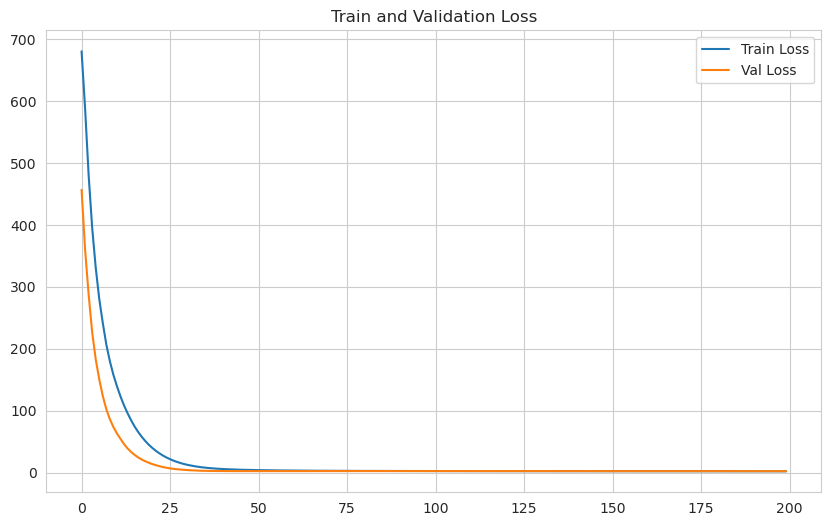

In [171]:
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="Val Loss")

plt.title("Train and Validation Loss")

plt.legend()
plt.show()

# Test

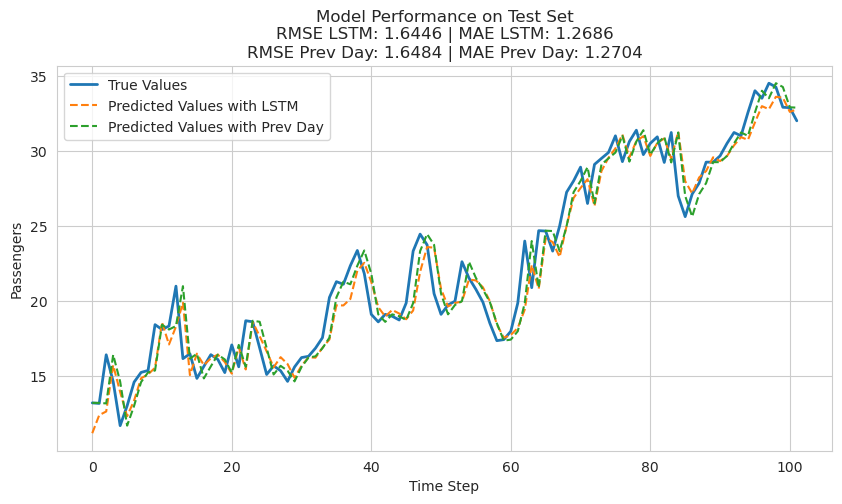

In [172]:
# Predictions with LSTM
targets = []
outputs = []
lstm.eval()
with torch.no_grad():
    for inputs, target in test_loader:
        output = lstm(inputs)  # Assuming the LSTM returns a tuple (output, hidden)
        outputs.append(output)
        targets.append(target)

preds = torch.cat(outputs).numpy().flatten()
targets = torch.cat(targets).numpy().flatten()

rmse_lstm = np.sqrt(np.mean((targets - preds) ** 2))
mae_lstm = np.mean(np.abs(targets - preds))

# Predictions with previous day value
y_pred_prev_day = np.roll(targets, 1)
y_pred_prev_day[0] = targets[0]  # Or some other initial value if 13.0 is not suitable
rmse_prev_day_pred = np.sqrt(np.mean((targets - y_pred_prev_day) ** 2))
mae_prev_day_pred = np.mean(np.abs(targets - y_pred_prev_day))

# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(targets, label="True Values", linewidth=2)
plt.plot(preds, label="Predicted Values with LSTM", linestyle="--")
plt.plot(y_pred_prev_day, label="Predicted Values with Prev Day", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Passengers")
plt.title(
    f"Model Performance on Test Set\n"
    f"RMSE LSTM: {rmse_lstm:.4f} | MAE LSTM: {mae_lstm:.4f}\n"
    f"RMSE Prev Day: {rmse_prev_day_pred:.4f} | MAE Prev Day: {mae_prev_day_pred:.4f}"
)
plt.legend()
plt.show()